# Como ler os resultados 
catalogo_long: painel longo com (ano, coluna, grupo, nulos_%)

pivot_cont / pivot_ind: evolução por coluna (linhas=colunas; colunas=anos)

resumo_grupo: estatísticas por ano+grupo (média/mediana/p90/max).

criticas_por_ano: colunas com % de nulos ≥ LIMIAR_CRITICO em cada ano.

tend_cont / tend_ind: ranking de pior tendência (Δ% 2008–2001). Valores positivos = piora, negativos = melhora.


In [ ]:
# !pip install pandas openpyxl
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# 2001 até 2008

# Análise dados faltantes

<Figure size 640x480 with 0 Axes>

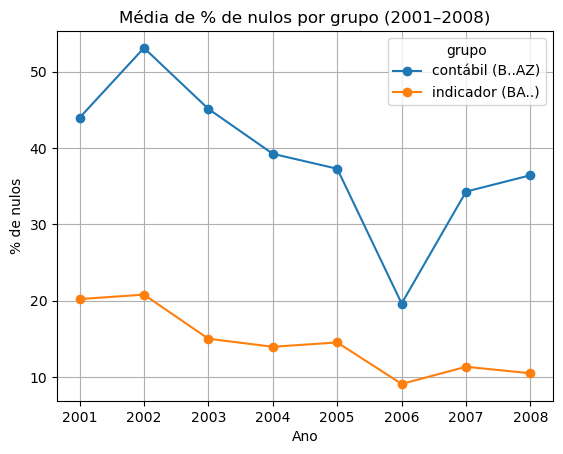

In [6]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.float_format", lambda v: f"{v:,.2f}")

ARQUIVO = "dados_2001_2008.xlsx"   # ajuste o caminho local
ANOS = list(range(2001, 2009))     # 2001–2008
LIMIAR_CRITICO = 50.0              # % de nulos para marcar "críticas"
EXPORTAR_RELATORIO = True
SAIDA_XLSX = "nulos_2001_2008.xlsx"

def detectar_ops_col(cols):
    """Encontra a coluna OPS (case-insensitive). Se não achar, assume a primeira coluna."""
    for i, c in enumerate(cols):
        if str(c).strip().lower() == "ops":
            return i, True
    return 0, False

def grupos_por_posicao(cols):
    """
    Mapeia por posição absoluta:
      A = OPS (índice 0)
      B..AZ = contábeis (índices 1..51, inclusivo)
      BA..fim = indicadores (índices 52..)
    """
    accounting_idx_ini, accounting_idx_fim = 1, 51  # inclusivo
    indicator_idx_ini = 52
    accounting_cols = [cols[i] for i in range(accounting_idx_ini, min(accounting_idx_fim+1, len(cols)))]
    indicator_cols  = [cols[i] for i in range(indicator_idx_ini, len(cols))]
    return accounting_cols, indicator_cols

def limpar_linhas_irrelevantes(df, ops_colname):
    """Remove '(vazio)' e 'Total Geral', e linhas com OPS nulo."""
    df2 = df.copy()
    ops_str = df2[ops_colname].astype(str).str.strip().str.lower()
    mask_descartar = ops_str.isin(["(vazio)", "total geral"])
    mask_nan = df2[ops_colname].isna()
    return df2[~(mask_descartar | mask_nan)]

def faixa_pct(p):
    if pd.isna(p): return "NA"
    if p == 0: return "0%"
    if p <= 1: return "0-1%"
    if p <= 5: return "1-5%"
    if p <= 10: return "5-10%"
    if p <= 30: return "10-30%"
    if p <= 50: return "30-50%"
    if p <= 90: return "50-90%"
    if p < 100: return "90-<100%"
    return "100%"

from collections import defaultdict

path = Path(ARQUIVO)
assert path.exists(), f"Arquivo não encontrado: {path}"

registros = []          # long-form: uma linha por (ano, coluna)
resumo_meta = []        # metadados por ano
cols_por_ano = {}       # dicionário: ano -> colunas (lista)

for ano in ANOS:
    aba = str(ano)
    df = pd.read_excel(path, sheet_name=aba)
    df.columns = [str(c).strip() for c in df.columns]
    cols = df.columns.tolist()
    cols_por_ano[ano] = cols

    ops_idx, _ = detectar_ops_col(cols)
    ops_col = cols[ops_idx]
    cont_cols, ind_cols = grupos_por_posicao(cols)
    df = limpar_linhas_irrelevantes(df, ops_col)

    n_linhas = len(df)
    isna = df.isna()
    col_nulos = isna.sum()
    col_pct = (col_nulos / max(n_linhas, 1) * 100).astype(float)

    def grupo_da_coluna(c):
        if c == ops_col: return "identificador (OPS)"
        if c in cont_cols: return "contábil (B..AZ)"
        if c in ind_cols:  return "indicador (BA..)"
        return "outros"

    for c in cols:
        registros.append({
            "ano": ano,
            "coluna": c,
            "grupo": grupo_da_coluna(c),
            "nulos": int(col_nulos[c]),
            "nulos_%": float(col_pct[c]) if not pd.isna(col_pct[c]) else np.nan,
            "dtype": str(df[c].dtype),
            "n_unique": int(df[c].nunique(dropna=True)),
            "linhas_utilizadas": n_linhas
        })

    # resumo por grupo do ano
    cat = pd.DataFrame({
        "coluna": cols,
        "grupo": [grupo_da_coluna(c) for c in cols],
        "nulos_%": [float(col_pct[c]) if not pd.isna(col_pct[c]) else np.nan for c in cols],
    })
    cat_filtro = cat[cat["grupo"].isin(["contábil (B..AZ)", "indicador (BA..)"])]
    resumo_meta.append({
        "ano": ano,
        "qtd_linhas": n_linhas,
        "qtd_colunas_totais": len(cols),
        "qtd_contabeis": int((cat["grupo"]=="contábil (B..AZ)").sum()),
        "qtd_indicadores": int((cat["grupo"]=="indicador (BA..)").sum()),
        "media_nulos_contabeis_%": float(cat_filtro[cat_filtro["grupo"]=="contábil (B..AZ)"]["nulos_%"].mean()),
        "media_nulos_indicadores_%": float(cat_filtro[cat_filtro["grupo"]=="indicador (BA..)"]["nulos_%"].mean()),
    })

catalogo_long = pd.DataFrame(registros)
resumo_ano = pd.DataFrame(resumo_meta).sort_values("ano")
catalogo_long.head(10)

# Filtrar apenas contábeis e indicadores
long_cont = catalogo_long[catalogo_long["grupo"]=="contábil (B..AZ)"][["ano","coluna","nulos_%"]]
long_ind  = catalogo_long[catalogo_long["grupo"]=="indicador (BA..)"][["ano","coluna","nulos_%"]]

pivot_cont = long_cont.pivot_table(index="coluna", columns="ano", values="nulos_%", aggfunc="mean")
pivot_ind  = long_ind.pivot_table(index="coluna", columns="ano", values="nulos_%", aggfunc="mean")

# Ordenar por média ao longo dos anos (pior primeiro)
pivot_cont["media_%"] = pivot_cont.mean(axis=1, skipna=True)
pivot_ind["media_%"]  = pivot_ind.mean(axis=1, skipna=True)
pivot_cont = pivot_cont.sort_values("media_%", ascending=False)
pivot_ind  = pivot_ind.sort_values("media_%", ascending=False)

pivot_cont.head(15), pivot_ind.head(15)

# Tabela "críticas" (por ano)
criticas_por_ano = (
    catalogo_long[(catalogo_long["grupo"].isin(["contábil (B..AZ)","indicador (BA..)"])) &
                  (catalogo_long["nulos_%"] >= LIMIAR_CRITICO)]
    .sort_values(["ano","grupo","nulos_%"], ascending=[True, True, False])
    .reset_index(drop=True)
)

# Tendência simples por coluna: delta_% = 2008 - 2001 (quando existirem ambos)
def tendencia_delta(pivot):
    anos_cols = [a for a in pivot.columns if isinstance(a, int)]
    if len(anos_cols) == 0:
        return pd.DataFrame(columns=["coluna","media_%","delta_2008_2001"])
    base = pivot.copy()
    base["delta_2008_2001"] = base.get(2008) - base.get(2001)
    out = base[["media_%","delta_2008_2001"]].sort_values("delta_2008_2001", ascending=False)
    out = out.reset_index().rename(columns={"index":"coluna"})
    return out

tend_cont = tendencia_delta(pivot_cont)
tend_ind  = tendencia_delta(pivot_ind)

criticas_por_ano.head(20), tend_cont.head(20), tend_ind.head(20)

# Estatísticas por grupo/ano (média/mediana/p90/max das colunas daquele grupo)
def resumo_grupo_ano(df_long):
    f = df_long[df_long["grupo"].isin(["contábil (B..AZ)","indicador (BA..)"])]
    out = (f.groupby(["ano","grupo"])["nulos_%"]
             .agg(media="mean", mediana="median",
                  p90=lambda x: float(np.nanpercentile(x, 90)) if len(x)>0 else np.nan,
                  max="max",
                  count="count")
             .reset_index()
             .sort_values(["ano","grupo"]))
    return out

resumo_grupo = resumo_grupo_ano(catalogo_long)
resumo_grupo

def style_pct(df_in, pct_cols=None):
    sty = df_in.style
    if pct_cols is None:
        pct_cols = [c for c in df_in.columns if isinstance(c, (int, np.integer))]  # anos no pivot
    fmt = {c: "{:.2f}%" for c in pct_cols if c in df_in.columns}
    if fmt:
        sty = sty.format(fmt)
    return sty

style_pct(pivot_cont.head(30))

tmp = (resumo_grupo.pivot_table(index="ano", columns="grupo", values="media")
                   .reindex(ANOS))
plt.figure()
tmp.plot(marker="o")  # sem definir cores; usa o padrão
plt.title("Média de % de nulos por grupo (2001–2008)")
plt.xlabel("Ano")
plt.ylabel("% de nulos")
plt.grid(True)
plt.show()


# Exportar em Excel

In [7]:
if EXPORTAR_RELATORIO:
    with pd.ExcelWriter(SAIDA_XLSX, engine="openpyxl") as writer:
        # meta
        meta = pd.DataFrame({
            "anos": [f"{ANOS[0]}–{ANOS[-1]}"],
            "arquivo": [ARQUIVO],
            "limiar_critico_%": [LIMIAR_CRITICO],
        })
        meta.to_excel(writer, sheet_name="00_meta", index=False)

        # resumo anual
        resumo_ano.to_excel(writer, sheet_name="01_resumo_ano", index=False)

        # catálogo longo
        cat_save = catalogo_long.copy()
        cat_save["faixa_nulos"] = cat_save["nulos_%"].apply(faixa_pct)
        cat_save.to_excel(writer, sheet_name="02_catalogo_long", index=False)

        # resumo por grupo/ano
        resumo_grupo.to_excel(writer, sheet_name="03_resumo_grupo_ano", index=False)

        # pivôs
        pivot_cont.to_excel(writer, sheet_name="04_pivot_contabeis")
        pivot_ind.to_excel(writer, sheet_name="05_pivot_indicadores")

        # críticas e tendências
        criticas_por_ano.to_excel(writer, sheet_name="06_criticas_por_ano", index=False)
        tend_cont.to_excel(writer, sheet_name="07_tend_contabeis", index=False)
        tend_ind.to_excel(writer, sheet_name="08_tend_indicadores", index=False)

        # colunas por ano (pra auditoria)
        for ano, cols in cols_por_ano.items():
            pd.DataFrame({"colunas": cols}).to_excel(writer, sheet_name=f"cols_{ano}", index=False)

    print(f"Relatório salvo em: {Path(SAIDA_XLSX).resolve()}")


Relatório salvo em: C:\Users\tetat\Desktop\Arquivos\Gestão\Eu\Acadêmico\Mestrado\Extensões\Fapemig\Dados\nulos_2001_2008.xlsx


# Modelagem

## 2009 até 2016

Resumo 2009–2016 (média por grupo):


grupo,contábil (B..AZ),indicador (BA..)
ano,,
2009,25.03,6.33
2010,24.16,0.19
2011,23.96,0.26
2012,22.70,0.65
2013,20.75,0.16
2014,21.67,0.08
2015,20.18,0.88
2016,21.64,0.13


<Figure size 640x480 with 0 Axes>

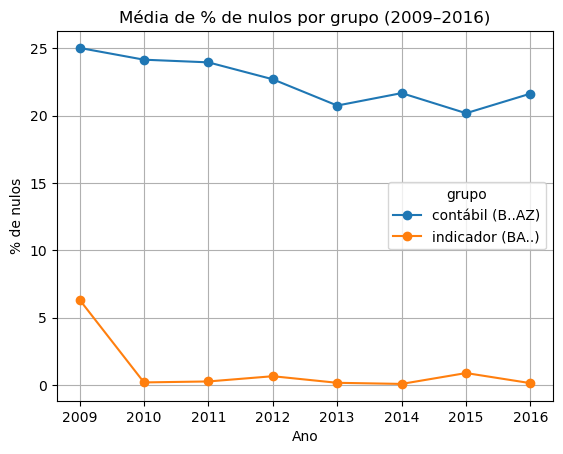

ano,2009,2010,2011,2012,2013,2014,2015,2016,media_%
coluna,,,,,,,,,
6119,96.36,96.41,96.07,55.26,95.88,95.24,95.59,95.74,90.82
322,NaN,84.30,83.52,84.18,NaN,NaN,NaN,NaN,84.00
3119,82.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.30
312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.97,79.97
219,77.47,78.55,78.31,77.47,77.75,77.98,76.64,77.32,77.69
214,81.86,79.07,65.91,62.59,62.07,61.69,60.35,59.34,66.61
332,91.67,92.45,93.05,92.28,31.04,31.37,30.26,31.12,61.65
4638,59.85,58.82,57.52,57.60,55.50,55.48,55.94,54.05,56.85
124,67.43,65.47,52.08,51.05,48.30,48.23,47.88,46.80,53.41


ano,2009,2010,2011,2012,2013,2014,2015,2016,media_%
coluna,,,,,,,,,
MLO,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00
COMBA,0.00,2.62,3.63,2.26,1.74,1.13,1.41,1.45,1.78
COMB,0.00,0.00,0.00,6.16,0.00,0.00,5.65,0.00,1.48
LG,1.26,0.00,0.00,0.00,NaN,0.00,NaN,NaN,0.25
CE,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PMCR,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
MARG. EBIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00
MARG EBITDA,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
MARG EBIT,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00


,ano,coluna,grupo,nulos,nulos_%,dtype,n_unique,linhas_utilizadas
0,2009,6119,contábil (B..AZ),1296,96.36,float64,28,1345
1,2009,332,contábil (B..AZ),1233,91.67,float64,91,1345
2,2009,3119,contábil (B..AZ),1107,82.30,float64,208,1345
3,2009,214,contábil (B..AZ),1101,81.86,float64,180,1345
4,2009,219,contábil (B..AZ),1042,77.47,float64,243,1345
5,2009,124,contábil (B..AZ),907,67.43,float64,380,1345
6,2009,6111,contábil (B..AZ),830,61.71,float64,466,1345
7,2009,6112,contábil (B..AZ),829,61.64,float64,467,1345
8,2009,4638,contábil (B..AZ),805,59.85,float64,508,1345
9,2009,35,contábil (B..AZ),803,59.70,float64,515,1345


ano,coluna,media_%,delta
0,34,42.61,68.29
1,231,46.37,43.05
2,41,10.87,5.86
3,13,3.91,3.03
4,23,22.93,2.14
5,43,37.95,0.84
6,4637,12.33,0.60
7,21,1.15,0.47
8,46,0.87,0.40
9,218,3.50,0.33


ano,coluna,media_%,delta
0,COMBA,1.78,1.45
1,COMB,1.48,0.00
2,CE,0.00,0.00
3,PMCR,0.00,0.00
4,MARG EBITDA,0.00,0.00
5,IMOB,0.00,0.00
6,DC,0.00,0.00
7,DA,0.00,0.00
8,PMPE,0.00,0.00
9,MLO,100.00,NaN


In [11]:

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.float_format", lambda v: f"{v:,.2f}")

ARQUIVO = "dados_2009_2016.xlsx"  # ajuste o caminho local
ANOS = list(range(2009, 2017))    # 2009–2016
LIMIAR_CRITICO = 50.0             # % de nulos considerado "crítico"
EXPORTAR_RELATORIO = True
SAIDA_XLSX = "nulos_2009_2016.xlsx"

def detectar_ops_col(cols):
    for i, c in enumerate(cols):
        if str(c).strip().lower() == "ops":
            return i, True
    return 0, False

def grupos_por_posicao(cols):
    # A=0 -> OPS | B..AZ => 1..51 | BA.. => 52..
    accounting_idx_ini, accounting_idx_fim = 1, 51
    indicator_idx_ini = 52
    accounting_cols = [cols[i] for i in range(accounting_idx_ini, min(accounting_idx_fim+1, len(cols)))]
    indicator_cols  = [cols[i] for i in range(indicator_idx_ini, len(cols))]
    return accounting_cols, indicator_cols

def limpar_linhas_irrelevantes(df, ops_colname):
    df2 = df.copy()
    ops_str = df2[ops_colname].astype(str).str.strip().str.lower()
    mask_descartar = ops_str.isin(["(vazio)", "total geral"])
    mask_nan = df2[ops_colname].isna()
    return df2[~(mask_descartar | mask_nan)]

def faixa_pct(p):
    if pd.isna(p): return "NA"
    if p == 0: return "0%"
    if p <= 1: return "0-1%"
    if p <= 5: return "1-5%"
    if p <= 10: return "5-10%"
    if p <= 30: return "10-30%"
    if p <= 50: return "30-50%"
    if p <= 90: return "50-90%"
    if p < 100: return "90-<100%"
    return "100%"

def tendencia_delta(pivot, ano_ini, ano_fim):
    base = pivot.copy()
    anos_cols = [c for c in base.columns if isinstance(c, (int, np.integer))]
    if len(anos_cols) == 0:
        return pd.DataFrame(columns=["coluna","media_%","delta"])
    base["delta"] = base.get(ano_fim) - base.get(ano_ini)
    out = base[["media_%","delta"]].sort_values("delta", ascending=False).reset_index().rename(columns={"index":"coluna"})
    return out

path = Path(ARQUIVO)
assert path.exists(), f"Arquivo não encontrado: {path}"

registros = []
resumo_meta = []
cols_por_ano = {}

for ano in ANOS:
    aba = str(ano)
    df = pd.read_excel(path, sheet_name=aba)
    df.columns = [str(c).strip() for c in df.columns]
    cols = df.columns.tolist()
    cols_por_ano[ano] = cols

    ops_idx, _ = detectar_ops_col(cols)
    ops_col = cols[ops_idx]
    cont_cols, ind_cols = grupos_por_posicao(cols)
    df = limpar_linhas_irrelevantes(df, ops_col)

    n_linhas = len(df)
    isna = df.isna()
    col_nulos = isna.sum()
    col_pct = (col_nulos / max(n_linhas, 1) * 100).astype(float)

    def grupo_da_coluna(c):
        if c == ops_col: return "identificador (OPS)"
        if c in cont_cols: return "contábil (B..AZ)"
        if c in ind_cols:  return "indicador (BA..)"
        return "outros"

    # long-form
    for c in cols:
        registros.append({
            "ano": ano,
            "coluna": c,
            "grupo": grupo_da_coluna(c),
            "nulos": int(col_nulos[c]),
            "nulos_%": float(col_pct[c]) if not pd.isna(col_pct[c]) else np.nan,
            "dtype": str(df[c].dtype),
            "n_unique": int(df[c].nunique(dropna=True)),
            "linhas_utilizadas": n_linhas
        })

    # resumo por grupo do ano
    cat = pd.DataFrame({"coluna": cols,
                        "grupo": [grupo_da_coluna(c) for c in cols],
                        "nulos_%": [float(col_pct[c]) if not pd.isna(col_pct[c]) else np.nan for c in cols],})
    cat_f = cat[cat["grupo"].isin(["contábil (B..AZ)", "indicador (BA..)"])]
    resumo_meta.append({
        "ano": ano,
        "qtd_linhas": n_linhas,
        "qtd_colunas_totais": len(cols),
        "qtd_contabeis": int((cat["grupo"]=="contábil (B..AZ)").sum()),
        "qtd_indicadores": int((cat["grupo"]=="indicador (BA..)").sum()),
        "media_nulos_contabeis_%": float(cat_f[cat_f["grupo"]=="contábil (B..AZ)"]["nulos_%"].mean()),
        "media_nulos_indicadores_%": float(cat_f[cat_f["grupo"]=="indicador (BA..)"]["nulos_%"].mean()),
    })

catalogo_long_0916 = pd.DataFrame(registros)
resumo_ano_0916 = pd.DataFrame(resumo_meta).sort_values("ano")

# pivôs
f_cont = catalogo_long_0916[catalogo_long_0916["grupo"]=="contábil (B..AZ)"][["ano","coluna","nulos_%"]]
f_ind  = catalogo_long_0916[catalogo_long_0916["grupo"]=="indicador (BA..)"][["ano","coluna","nulos_%"]]

pivot_cont_0916 = f_cont.pivot_table(index="coluna", columns="ano", values="nulos_%", aggfunc="mean")
pivot_ind_0916  = f_ind.pivot_table(index="coluna", columns="ano", values="nulos_%", aggfunc="mean")

pivot_cont_0916["media_%"] = pivot_cont_0916.mean(axis=1, skipna=True)
pivot_ind_0916["media_%"]  = pivot_ind_0916.mean(axis=1, skipna=True)
pivot_cont_0916 = pivot_cont_0916.sort_values("media_%", ascending=False)
pivot_ind_0916  = pivot_ind_0916.sort_values("media_%", ascending=False)

# críticas e tendências
criticas_0916 = (
    catalogo_long_0916[(catalogo_long_0916["grupo"].isin(["contábil (B..AZ)","indicador (BA..)"])) &
                       (catalogo_long_0916["nulos_%"] >= LIMIAR_CRITICO)]
    .sort_values(["ano","grupo","nulos_%"], ascending=[True, True, False])
    .reset_index(drop=True)
)

tend_cont_0916 = tendencia_delta(pivot_cont_0916, ANOS[0], ANOS[-1])
tend_ind_0916  = tendencia_delta(pivot_ind_0916, ANOS[0], ANOS[-1])

# resumo por grupo/ano
resumo_grupo_0916 = (catalogo_long_0916[catalogo_long_0916["grupo"].isin(["contábil (B..AZ)","indicador (BA..)"])]
                      .groupby(["ano","grupo"])["nulos_%"]
                      .agg(media="mean", mediana="median",
                           p90=lambda x: float(np.nanpercentile(x, 90)) if len(x)>0 else np.nan,
                           max="max", count="count")
                      .reset_index()
                      .sort_values(["ano","grupo"]))


print("Resumo 2009–2016 (média por grupo):")
tmp = (resumo_grupo_0916.pivot_table(index="ano", columns="grupo", values="media")
                   .reindex(ANOS))
display(tmp)

plt.figure()
tmp.plot(marker="o")
plt.title("Média de % de nulos por grupo (2009–2016)")
plt.xlabel("Ano"); plt.ylabel("% de nulos"); plt.grid(True); plt.show()

display(pivot_cont_0916.head(15))
display(pivot_ind_0916.head(15))
display(criticas_0916.head(20))
display(tend_cont_0916.head(20))
display(tend_ind_0916.head(20))

## Exportar em Excel

In [12]:
if EXPORTAR_RELATORIO:
    with pd.ExcelWriter(SAIDA_XLSX, engine="openpyxl") as w:
        pd.DataFrame({"arquivo":[ARQUIVO],"anos":[f"{ANOS[0]}–{ANOS[-1]}"],"limiar_%":[LIMIAR_CRITICO]}).to_excel(w,"00_meta",index=False)
        resumo_ano_0916.to_excel(w,"01_resumo_ano",index=False)
        cat_save = catalogo_long_0916.copy()
        cat_save["faixa_nulos"] = cat_save["nulos_%"].apply(faixa_pct)
        cat_save.to_excel(w,"02_catalogo_long",index=False)
        resumo_grupo_0916.to_excel(w,"03_resumo_grupo_ano",index=False)
        pivot_cont_0916.to_excel(w,"04_pivot_contabeis")
        pivot_ind_0916.to_excel(w,"05_pivot_indicadores")
        criticas_0916.to_excel(w,"06_criticas_por_ano",index=False)
        tend_cont_0916.to_excel(w,"07_tend_contabeis",index=False)
        tend_ind_0916.to_excel(w,"08_tend_indicadores",index=False)
        for ano, cols in cols_por_ano.items():
            pd.DataFrame({"colunas": cols}).to_excel(w, f"cols_{ano}", index=False)
    print(f"Relatório salvo em: {Path(SAIDA_XLSX).resolve()}")


C:\Users\tetat\AppData\Local\Temp\ipykernel_1852\2247309075.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame({"arquivo":[ARQUIVO],"anos":[f"{ANOS[0]}–{ANOS[-1]}"],"limiar_%":[LIMIAR_CRITICO]}).to_excel(w,"00_meta",index=False)
C:\Users\tetat\AppData\Local\Temp\ipykernel_1852\2247309075.py:4: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  resumo_ano_0916.to_excel(w,"01_resumo_ano",index=False)
C:\Users\tetat\AppData\Local\Temp\ipykernel_1852\2247309075.py:7: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  cat_save.to_excel(w,"02_catalogo_long",index=False)
C:\Users\tetat\AppData\Local\Temp\ipykernel_1852\2247309075.py:8: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for t

Relatório salvo em: C:\Users\tetat\Desktop\Arquivos\Gestão\Eu\Acadêmico\Mestrado\Extensões\Fapemig\Dados\nulos_2009_2016.xlsx


## 2017 até 2024

Resumo 2017–2024 (média por grupo):


grupo,contábil (B..AZ),indicador (BA..)
ano,,
2017,24.77,10.11
2018,24.98,10.25
2019,24.59,10.60
2020,25.23,10.44
2021,24.22,11.47
2022,23.95,11.44
2023,23.18,11.00
2024,22.77,10.76


<Figure size 640x480 with 0 Axes>

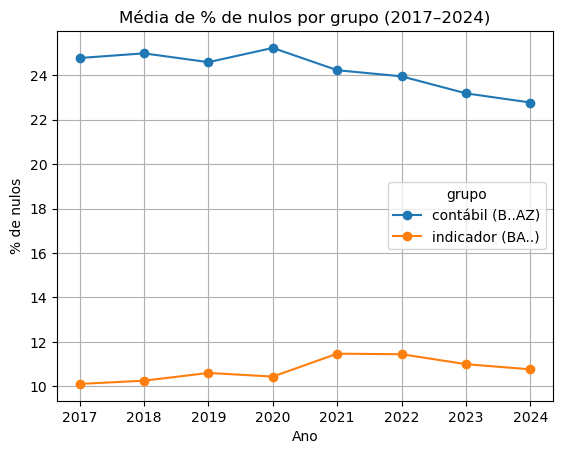

ano,2017,2018,2019,2020,2021,2022,2023,2024,media_%
coluna,,,,,,,,,
6119,94.77,93.71,91.69,90.68,90.12,90.17,89.09,88.36,91.07
2148,79.10,80.05,79.91,78.01,78.02,78.20,77.42,76.13,78.35
219,71.39,71.70,70.23,69.52,68.51,69.11,67.08,66.34,69.24
34,69.26,69.00,67.40,66.54,65.65,65.49,63.95,63.80,66.39
231,58.28,57.95,57.44,56.94,57.34,56.40,54.65,53.33,56.54
214,53.41,54.09,52.88,51.35,52.45,50.46,50.47,50.10,51.90
2132,58.55,57.41,54.25,52.28,48.94,47.50,46.39,45.01,51.29
217,46.50,48.61,49.68,52.84,54.39,51.02,50.00,49.02,50.26
4638,50.58,49.33,48.77,47.90,47.74,49.07,47.06,47.95,48.55


ano,2017,2018,2019,2020,2021,2022,2023,2024,media_%
coluna,,,,,,,,,
Unnamed: 79,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
Unnamed: 60,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
Unnamed: 52,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
PMPE,15.23,15.18,16.16,17.05,18.56,19.29,18.88,18.88,17.41
COMB,4.43,4.49,5.75,5.03,6.93,8.07,7.12,6.16,6.00
DA,4.43,4.49,5.75,5.03,6.93,8.07,7.12,6.16,6.00
DC,4.43,4.49,5.75,5.03,6.93,8.07,7.12,6.16,6.00
DM,4.43,4.49,5.75,5.03,6.93,8.07,7.12,6.16,6.00
PCMR,4.43,4.49,5.75,5.03,6.93,8.07,7.12,6.16,6.00


,ano,coluna,grupo,nulos,nulos_%,dtype,n_unique,linhas_utilizadas
0,2017,6119,contábil (B..AZ),1070,94.77,float64,50,1129
1,2017,2148,contábil (B..AZ),893,79.10,float64,130,1129
2,2017,219,contábil (B..AZ),806,71.39,float64,229,1129
3,2017,34,contábil (B..AZ),782,69.26,float64,275,1129
4,2017,2132,contábil (B..AZ),661,58.55,float64,362,1129
5,2017,231,contábil (B..AZ),658,58.28,float64,382,1129
6,2017,214,contábil (B..AZ),603,53.41,float64,409,1129
7,2017,4638,contábil (B..AZ),571,50.58,float64,492,1129
8,2017,Unnamed: 52,indicador (BA..),1129,100.00,float64,0,1129
9,2017,Unnamed: 60,indicador (BA..),1129,100.00,float64,0,1129


ano,coluna,media_%,delta
0,211,14.44,3.17
1,311,13.79,2.79
2,217,50.26,2.52
3,4637,12.22,2.24
4,332,26.98,1.97
5,41,14.20,1.82
6,411,14.44,1.75
7,133,8.28,1.68
8,31,4.72,1.62
9,123,5.09,1.31


ano,coluna,media_%,delta
0,PMPE,17.41,3.65
1,MARGEM EBIT,6.00,1.74
2,COMB,6.00,1.74
3,DA,6.00,1.74
4,DC,6.00,1.74
5,DM,6.00,1.74
6,PCMR,6.00,1.74
7,MLL,6.00,1.74
8,MLB,6.00,1.74
9,MARGEM EBITDA,6.00,1.74


In [14]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.float_format", lambda v: f"{v:,.2f}")

ARQUIVO = "dados_2017_2024.xlsx"  # ajuste o caminho local
ANOS = list(range(2017, 2025))    # 2017–2024
LIMIAR_CRITICO = 50.0
EXPORTAR_RELATORIO = True
SAIDA_XLSX = "nulos_2017_2024.xlsx"


def detectar_ops_col(cols):
    for i, c in enumerate(cols):
        if str(c).strip().lower() == "ops":
            return i, True
    return 0, False

def grupos_por_posicao(cols):
    accounting_idx_ini, accounting_idx_fim = 1, 51
    indicator_idx_ini = 52
    accounting_cols = [cols[i] for i in range(accounting_idx_ini, min(accounting_idx_fim+1, len(cols)))]
    indicator_cols  = [cols[i] for i in range(indicator_idx_ini, len(cols))]
    return accounting_cols, indicator_cols

def limpar_linhas_irrelevantes(df, ops_colname):
    df2 = df.copy()
    ops_str = df2[ops_colname].astype(str).str.strip().str.lower()
    mask_descartar = ops_str.isin(["(vazio)", "total geral"])
    mask_nan = df2[ops_colname].isna()
    return df2[~(mask_descartar | mask_nan)]

def faixa_pct(p):
    if pd.isna(p): return "NA"
    if p == 0: return "0%"
    if p <= 1: return "0-1%"
    if p <= 5: return "1-5%"
    if p <= 10: return "5-10%"
    if p <= 30: return "10-30%"
    if p <= 50: return "30-50%"
    if p <= 90: return "50-90%"
    if p < 100: return "90-<100%"
    return "100%"

def tendencia_delta(pivot, ano_ini, ano_fim):
    base = pivot.copy()
    anos_cols = [c for c in base.columns if isinstance(c, (int, np.integer))]
    if len(anos_cols) == 0:
        return pd.DataFrame(columns=["coluna","media_%","delta"])
    base["delta"] = base.get(ano_fim) - base.get(ano_ini)
    out = base[["media_%","delta"]].sort_values("delta", ascending=False).reset_index().rename(columns={"index":"coluna"})
    return out

path = Path(ARQUIVO)
assert path.exists(), f"Arquivo não encontrado: {path}"

registros = []
resumo_meta = []
cols_por_ano = {}

for ano in ANOS:
    aba = str(ano)
    df = pd.read_excel(path, sheet_name=aba)
    df.columns = [str(c).strip() for c in df.columns]
    cols = df.columns.tolist()
    cols_por_ano[ano] = cols

    ops_idx, _ = detectar_ops_col(cols)
    ops_col = cols[ops_idx]
    cont_cols, ind_cols = grupos_por_posicao(cols)
    df = limpar_linhas_irrelevantes(df, ops_col)

    n_linhas = len(df)
    isna = df.isna()
    col_nulos = isna.sum()
    col_pct = (col_nulos / max(n_linhas, 1) * 100).astype(float)

    def grupo_da_coluna(c):
        if c == ops_col: return "identificador (OPS)"
        if c in cont_cols: return "contábil (B..AZ)"
        if c in ind_cols:  return "indicador (BA..)"
        return "outros"

    for c in cols:
        registros.append({
            "ano": ano,
            "coluna": c,
            "grupo": grupo_da_coluna(c),
            "nulos": int(col_nulos[c]),
            "nulos_%": float(col_pct[c]) if not pd.isna(col_pct[c]) else np.nan,
            "dtype": str(df[c].dtype),
            "n_unique": int(df[c].nunique(dropna=True)),
            "linhas_utilizadas": n_linhas
        })

    cat = pd.DataFrame({"coluna": cols,
                        "grupo": [grupo_da_coluna(c) for c in cols],
                        "nulos_%": [float(col_pct[c]) if not pd.isna(col_pct[c]) else np.nan for c in cols],})
    cat_f = cat[cat["grupo"].isin(["contábil (B..AZ)", "indicador (BA..)"])]
    resumo_meta.append({
        "ano": ano,
        "qtd_linhas": n_linhas,
        "qtd_colunas_totais": len(cols),
        "qtd_contabeis": int((cat["grupo"]=="contábil (B..AZ)").sum()),
        "qtd_indicadores": int((cat["grupo"]=="indicador (BA..)").sum()),
        "media_nulos_contabeis_%": float(cat_f[cat_f["grupo"]=="contábil (B..AZ)"]["nulos_%"].mean()),
        "media_nulos_indicadores_%": float(cat_f[cat_f["grupo"]=="indicador (BA..)"]["nulos_%"].mean()),
    })

catalogo_long_1724 = pd.DataFrame(registros)
resumo_ano_1724 = pd.DataFrame(resumo_meta).sort_values("ano")

# pivôs
f_cont = catalogo_long_1724[catalogo_long_1724["grupo"]=="contábil (B..AZ)"][["ano","coluna","nulos_%"]]
f_ind  = catalogo_long_1724[catalogo_long_1724["grupo"]=="indicador (BA..)"][["ano","coluna","nulos_%"]]

pivot_cont_1724 = f_cont.pivot_table(index="coluna", columns="ano", values="nulos_%", aggfunc="mean")
pivot_ind_1724  = f_ind.pivot_table(index="coluna", columns="ano", values="nulos_%", aggfunc="mean")

pivot_cont_1724["media_%"] = pivot_cont_1724.mean(axis=1, skipna=True)
pivot_ind_1724["media_%"]  = pivot_ind_1724.mean(axis=1, skipna=True)
pivot_cont_1724 = pivot_cont_1724.sort_values("media_%", ascending=False)
pivot_ind_1724  = pivot_ind_1724.sort_values("media_%", ascending=False)

# críticas e tendências
criticas_1724 = (
    catalogo_long_1724[(catalogo_long_1724["grupo"].isin(["contábil (B..AZ)","indicador (BA..)"])) &
                       (catalogo_long_1724["nulos_%"] >= LIMIAR_CRITICO)]
    .sort_values(["ano","grupo","nulos_%"], ascending=[True, True, False])
    .reset_index(drop=True)
)

tend_cont_1724 = tendencia_delta(pivot_cont_1724, ANOS[0], ANOS[-1])
tend_ind_1724  = tendencia_delta(pivot_ind_1724, ANOS[0], ANOS[-1])

# resumo por grupo/ano
resumo_grupo_1724 = (catalogo_long_1724[catalogo_long_1724["grupo"].isin(["contábil (B..AZ)","indicador (BA..)"])]
                      .groupby(["ano","grupo"])["nulos_%"]
                      .agg(media="mean", mediana="median",
                           p90=lambda x: float(np.nanpercentile(x, 90)) if len(x)>0 else np.nan,
                           max="max", count="count")
                      .reset_index()
                      .sort_values(["ano","grupo"]))

print("Resumo 2017–2024 (média por grupo):")
tmp = (resumo_grupo_1724.pivot_table(index="ano", columns="grupo", values="media")
                   .reindex(ANOS))
display(tmp)

plt.figure()
tmp.plot(marker="o")
plt.title("Média de % de nulos por grupo (2017–2024)")
plt.xlabel("Ano"); plt.ylabel("% de nulos"); plt.grid(True); plt.show()

display(pivot_cont_1724.head(15))
display(pivot_ind_1724.head(15))
display(criticas_1724.head(20))
display(tend_cont_1724.head(20))
display(tend_ind_1724.head(20))

## Exportar em Excel

In [15]:
if EXPORTAR_RELATORIO:
    with pd.ExcelWriter(SAIDA_XLSX, engine="openpyxl") as w:
        pd.DataFrame({"arquivo":[ARQUIVO],"anos":[f"{ANOS[0]}–{ANOS[-1]}"],"limiar_%":[LIMIAR_CRITICO]}).to_excel(w,"00_meta",index=False)
        resumo_ano_1724.to_excel(w,"01_resumo_ano",index=False)
        cat_save = catalogo_long_1724.copy()
        cat_save["faixa_nulos"] = cat_save["nulos_%"].apply(faixa_pct)
        cat_save.to_excel(w,"02_catalogo_long",index=False)
        resumo_grupo_1724.to_excel(w,"03_resumo_grupo_ano",index=False)
        pivot_cont_1724.to_excel(w,"04_pivot_contabeis")
        pivot_ind_1724.to_excel(w,"05_pivot_indicadores")
        criticas_1724.to_excel(w,"06_criticas_por_ano",index=False)
        tend_cont_1724.to_excel(w,"07_tend_contabeis",index=False)
        tend_ind_1724.to_excel(w,"08_tend_indicadores",index=False)
        for ano, cols in cols_por_ano.items():
            pd.DataFrame({"colunas": cols}).to_excel(w, f"cols_{ano}", index=False)
    print(f"Relatório salvo em: {Path(SAIDA_XLSX).resolve()}")


C:\Users\tetat\AppData\Local\Temp\ipykernel_1852\1194795896.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame({"arquivo":[ARQUIVO],"anos":[f"{ANOS[0]}–{ANOS[-1]}"],"limiar_%":[LIMIAR_CRITICO]}).to_excel(w,"00_meta",index=False)
C:\Users\tetat\AppData\Local\Temp\ipykernel_1852\1194795896.py:4: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  resumo_ano_1724.to_excel(w,"01_resumo_ano",index=False)
C:\Users\tetat\AppData\Local\Temp\ipykernel_1852\1194795896.py:7: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  cat_save.to_excel(w,"02_catalogo_long",index=False)
C:\Users\tetat\AppData\Local\Temp\ipykernel_1852\1194795896.py:8: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for t

Relatório salvo em: C:\Users\tetat\Desktop\Arquivos\Gestão\Eu\Acadêmico\Mestrado\Extensões\Fapemig\Dados\nulos_2017_2024.xlsx
